<img src="https://upload.wikimedia.org/wikipedia/fr/b/bf/Universit%C3%A9_Laval_logo_et_texte.svg" width=200 align="right"><br>
<b> Optoélectronique GEL-4203 / GEL-7041 </b><br>
<b> Département de Génie Électrique et de Génie Informatique </b><br>
<b> Automne 2025 </b><br>
<b> Université Laval </b><br>


<h1><center> Travail 3 </center></h1>

##### Remise 
- Votre notebook (.ipynb) ou un document au format PDF contenant vos démarches, réponses clairement identifiées et vos scripts (Python, Matlab ou autre
- Sur la boîte de dépôt dans monportail
- Au plus tard le "à déterminer"
##### Équipe
- Ce travail est *individuel*

##### Pondération : 
<!-- - GEL-4203 : Ce travail vaut pour *5%* de la note finale
- GEL-7041 : Ce travail vaut pour *5%* de la note finale -->

## Identification
- **Nom** :
- **Matricule** :

## Consignes pour répondre aux questions
- Utilisez des cellules de Markdown pour fournir des explications écrites et des équations mathématiques.
    - Vous pouvez faire une équation $\LaTeX$ sur une ligne: $\sum_{n = 0}^\infty x^n$.
    - Vous pouvez faire une équation $\LaTeX$ centrée: $$\sum_{n = 0}^\infty x^n.$$
    - Vous pouvez imbriquer des listes:
        - Niveau 2
            - Niveau 3
- Utilisez des cellules de code pour effectuer vos calculs numériques. Prenez soin de bien commenter votre code, de choisir des noms de variables explicites et de "print()" vos réponses.
- N'hésitez-pas à encapsuler vos calculs répétés dans des fonctions. À plusieurs endroits, il vous sera suggéré de créer des fonctions spécifiques. Ce n'est pas obligatoire mais fortement conseillé.
- Seules les librairies suivantes sont permises. Parmi celles-ci figure les fonctions de résolution de guide d'onde 1D.

In [69]:
""" 
Librairies permises
N'utilisez que les librairies Python suivantes
"""
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cte
#from GEL4203_utils import guide_1d_analytique

In [70]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

""" Créé par Jonathan Cauchon pour le cours GEL-4203

Historique des modifs:

    - 20 sept 2020: guide_1d_analytique
        dans l'utilisation de la fonction estimate_beta, si aucune solution n'est trouvée, 
        guide_id_analytique augmente la resolution sur beta jusqu'à ce qu'une solution
        soit trouvée.



"""







def estimate_beta(wvl, t, n1, n2, n3, beta_res):
    """
        Function qui estime les solutions du guide d'onde plan
    """

    wvl = np.asarray(wvl)
    k = 2*np.pi/wvl
    beta = np.linspace(np.max([n1,n3])*k, n2*k, beta_res)[:-1]
    beta = beta if beta.ndim == 2 else np.expand_dims(beta, -1)
    wvl = wvl if wvl.ndim == 1 else np.expand_dims(wvl, 0)
    
    # TE
    h = np.sqrt((k*n2)**2 - beta**2)

    p = np.sqrt(beta**2 - (k*n3)**2)
    q = np.sqrt(beta**2 - (k*n1)**2)
    zero_TE = np.tan(h*t) - (p + q)/h/(1 - p*q/h**2)
    
    # TM
    p_ = p*(n2/n3)**2
    q_ = q*(n2/n1)**2
    zero_TM = np.tan(h*t) - (p_ + q_)/h/(1 - p_*q_/h**2)

    beta_TE = []
    beta_TM = []
    
    for i in range(beta.shape[-1]):
        # solution esitmée: croisement du zéro en direction négative (+ -> -)
        solutions_TE = np.where(np.sign(zero_TE[:-1,i]) - np.sign(zero_TE[1:,i]) == 2)[0]
        solutions_TM = np.where(np.sign(zero_TM[:-1,i]) - np.sign(zero_TM[1:,i]) == 2)[0]
        # print(solutions_TE, solutions_TM)
        # plt.plot(zero_TE)
        # plt.plot([0,beta.shape[0]], [0,0])
        # plt.ylim((-1,1))
        # plt.show()

        beta_sol_TE = beta[solutions_TE,i]
        beta_sol_TM = beta[solutions_TM,i]
        beta_TE.append(beta_sol_TE)
        beta_TM.append(beta_sol_TM)

    return beta_TE, beta_TM


def guide_1d_analytique(wvl, t, n1, n2, n3):
    """ Solution analytique du guide d'onde plan
        
    Paramètres:    
        wvl: longueur d'onde [m] (float, liste ou numpy array)
        t  : épaisseur du coeur [m] (float)
        n1, n2, n3: indices des trois régions (floats)
        
    retourne:
        neff_TE, neff_TM: les indices effectifs des modes TE et TM (les solutions).
                        Ce sont des listes de listes. Chaque sous-liste de la liste est pour
                        une longueur d'onde de 'wvl' et chaque item de la sous-liste contient
                        tous les indices supportés par le guide, en ordre croissant.
                        
    exemple d'usage:
        
        wvl = np.linspace(1530e-9,1560e-9,1000) # longueurs d'onde considérées
        neff_TE, neff_TM = guide_1d_analytique(wvl, 220e-9, 1.44, 3.45, 1.44)
        
        print(neff_TM[0][0]) # le mode TM fondamental (TM_0) à 1530 nm
    """

    wvl = np.asarray(wvl)
    wvl = wvl if wvl.ndim == 1 else np.expand_dims(wvl, 0)

    def equation_TE(beta):
        k = 2*np.pi/wvl
        h = np.sqrt((k*n2)**2 - beta**2)
        p = np.sqrt(beta**2 - (k*n3)**2)
        q = np.sqrt(beta**2 - (k*n1)**2)

        return np.tan(h*t) - (p + q)/h/(1 - p*q/h**2)
    
    def equation_TM(beta):
        k = 2*np.pi/wvl
        h = np.sqrt((k*n2)**2 - beta**2)
        p = np.sqrt(beta**2 - (k*n3)**2)
        q = np.sqrt(beta**2 - (k*n1)**2)
        p_ = p*(n2/n3)**2
        q_ = q*(n2/n1)**2

        return np.tan(h*t) - (p_ + q_)/h/(1 - p_*q_/h**2)

    beta_res = 1000
    beta_TE_estimate, beta_TM_estimate = estimate_beta(wvl, t, n1, n2, n3, beta_res)
    
    # si la solution est trop tight faut augmenter la résolution
    while (len(beta_TE_estimate[0]) < 1) or (len(beta_TM_estimate[0]) < 1):
        beta_res *= 10
        beta_TE_estimate, beta_TM_estimate = estimate_beta(wvl, t, n1, n2, n3, beta_res)

    # print(beta_TE_estimate, beta_TM_estimate)   
    neff_TE, neff_TM = [], []
    for i in range(wvl.shape[0]):
        for j in range(len(beta_TE_estimate[i])):
            beta_TE_estimate[i][j] = scipy.optimize.fsolve(equation_TE, beta_TE_estimate[i][j]).squeeze()
        for j in range(len(beta_TM_estimate[i])):
            beta_TM_estimate[i][j] = scipy.optimize.fsolve(equation_TM, beta_TM_estimate[i][j]).squeeze()

        neff_TE.append(np.flip(beta_TE_estimate[i]*wvl[i]/2/np.pi).tolist())
        neff_TM.append(np.flip(beta_TM_estimate[i]*wvl[i]/2/np.pi).tolist())
            

    return neff_TE, neff_TM


#print(guide_1d_analytique(1.5420401337792642e-06, 4.8e-07, 1.44, 2.874935678745237, 1.44))


def tracer_modes(wvl, t, n1, n2, n3, plot_TE=True, plot_TM=True,
                 num_mode = [0]):
    # num_mode : ordre du mode à tracer - 1= mode fondamental
    mu0 = 4*np.pi*1e-7
    epsilon0 = 8.85e-12
    eta = np.sqrt(mu0/epsilon0)
    c = 3e8

    assert type(wvl) == float, "Utiliser une seule longueur d'onde"
    neff_TE, neff_TM = guide_1d_analytique(wvl, t, n1, n2, n3)

    numPoints = 1000
    x1 = np.linspace(-3*t, -t/2, numPoints)
    x2 = np.linspace(-t/2, t/2, numPoints)
    x3 = np.linspace( t/2, 3*t, numPoints)
    x = np.hstack((x1,x2, x3))
    nx = np.hstack((n1*np.ones(numPoints), n2*np.ones(numPoints), n3*np.ones(numPoints)))

    fig, ax = plt.subplots(1,2,figsize=(8,4))
    ax[0].plot([-t/2*1e6,-t/2*1e6,t/2*1e6,t/2*1e6],[-2,2,2,-2], "k--")
    ax[1].plot([-t/2*1e6,-t/2*1e6,t/2*1e6,t/2*1e6],[-2,2,2,-2], "k--")
    
    
    if plot_TE:
        # for i, n in enumerate(neff_TE[0]):
        for ii in range(0,len(num_mode)): # pour pouvoir tracer seulement un mode voulu
            n = neff_TE[0][num_mode[ii]]
            beta = 2*np.pi*n/wvl
            k = 2*np.pi/wvl
            h = np.sqrt((k*n2)**2 - beta**2)
            p = np.sqrt(beta**2 - (k*n3)**2)
            q = np.sqrt(beta**2 - (k*n1)**2)
            E_field = np.hstack(( np.exp(q*(x1 + t/2)), 
                                (np.cos(h*(x2+t/2))+q/h*np.sin(h*(x2+t/2))),
                                (np.cos(h*t) + q/h*np.sin(h*t))*np.exp(-p*(x3 - t/2)) ))
            H_field = E_field*nx/eta
            ax[0].plot(x*1e6, E_field/np.max(np.abs(E_field)), label="TE"+str(num_mode[ii]))
            ax[1].plot(x*1e6, H_field/np.max(np.abs(H_field)), label="TE"+str(num_mode[ii]))

    if plot_TM:
        # for i, n in enumerate(neff_TM[0]):
        for ii in range(0,len(num_mode)): # pour pouvoir tracer seulement un mode voulu
            n = neff_TM[0][num_mode[ii]]
            beta = 2*np.pi*n/wvl
            k = 2*np.pi/wvl
            h = np.sqrt((k*n2)**2 - beta**2)
            p = np.sqrt(beta**2 - (k*n3)**2)
            q = np.sqrt(beta**2 - (k*n1)**2)
            p_ = p*(n2/n3)**2
            q_ = q*(n2/n1)**2
            H_field = np.hstack(( h/q_*np.exp(q*(x1 + t/2)), 
                                (h/q_*np.cos(h*(x2+t/2))+np.sin(h*(x2+t/2))),
                                (h/q_*np.cos(h*t) + np.sin(h*t))*np.exp(-p*(x3 - t/2)) ))
            H_field = np.hstack(( h/q_*np.exp(q*(x1+t/2)), 
                (h/q_*np.cos(h*(x2+t/2))+np.sin(h*(x2+t/2))), 
                (h/q_*np.cos(h*t)+np.sin(h*t))*np.exp(-p*(x3-t/2)) ))

            ax[1].plot(x*1e6, H_field/np.max(np.abs(H_field)), label="TM"+str(num_mode[ii]))  
            E_field = H_field*eta/nx  
            ax[0].plot(x*1e6, E_field/np.max(np.abs(E_field)), label="TM"+str(num_mode[ii]))

    
    ax[0].set_ylim((-1.1,1.1))
    ax[0].set_ylabel("E")
    ax[0].set_xlabel("y ($\mu$m)")
    ax[0].legend()

    
    ax[1].set_ylim((-1.1,1.1))
    ax[1].set_ylabel("H")
    ax[1].set_xlabel("y ($\mu$m)")
    ax[1].legend()

    plt.tight_layout()
    plt.show()
    
    return

def gen_PRBS(show=True,
             V_bias=0.5,
             delta_V=0.1,
             n_bit=100,
             bit_rate=1/1e-9):
    import scipy.signal
    ''' 
    Arguments d'entrée:
        - V_bias : tension DC en volts
        - delta_V : amplitude peak-to-peak de la tension AC en volts
        - n_bit : nombre de bits à simuler
        - bit_rate : débit binaire du signal
        
    Arguments de sortie:
        - signal_up : vecteur d'amplitude du sigal en volts
        - time_up : vecteur du temps en secondes
        
    * par défaut, le taux d'échantillonnage est fixé à 100 points par bit
    '''

    # - définir les limites de la tension appliquée
    V_min = V_bias - delta_V
    V_max = V_bias + delta_V

    # - définition du signal
    sample_per_bit = 100
    bit_duration = 1/bit_rate
    sample_duration = bit_duration/sample_per_bit # 1/sampling_rate
    sample = int(n_bit*sample_per_bit)
    signal_duration = sample*sample_duration

    # - vecteur de temps
    time = np.linspace(sample_duration,signal_duration,sample)
    print('Generating %i pseudo-random bits of %.2f ns' %(n_bit, bit_duration*1e9))
    # - vecteur d'amplitude pseudo-aléatoire des bits
    amplitude = np.random.randint(0, 2, n_bit)*2*delta_V + V_min 

    # - générer le signal
    signal = np.zeros(sample)
    for ii in range(0,n_bit):
        jj = ii*sample_per_bit
        signal[jj:jj+sample_per_bit] = amplitude[ii]

    # - ajouter des points et les transitions
    signal_up, time_up = scipy.signal.resample(signal, sample*100, time, window=sample_per_bit)

    # - tracer le signal
    if show:
        fig,ax0=plt.subplots(tight_layout=True, figsize=(12,5))
        ax0.set_title('Signal électrique appliqué au modulateur')
        ax0.plot(time_up*1e9, signal_up, 'r-', ms=2, lw=1)
        ax0.set_xlabel('Temps [ns]')
        ax0.set_ylabel('Tension [V]')
        ax0.set_xlim((0,signal_duration*1e9))
    
    return signal_up, time_up










<>:201: SyntaxWarning: invalid escape sequence '\m'
<>:207: SyntaxWarning: invalid escape sequence '\m'
<>:201: SyntaxWarning: invalid escape sequence '\m'
<>:207: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Éloi Blouin\AppData\Local\Temp\ipykernel_6500\3875525739.py:201: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_xlabel("y ($\mu$m)")
C:\Users\Éloi Blouin\AppData\Local\Temp\ipykernel_6500\3875525739.py:207: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set_xlabel("y ($\mu$m)")


### Question 1 - Conception d'une cavité Fabry-Péro (10%)
Pour ce problème, vous pouvez ignorer les effets de dispersion. Considérez un guide d'onde dont l'indice effectif est 2.45. À partir de ce guide d'onde, vous concevez une cavité Fabry-Pérot. Les pertes dans le guide d'onde sont $\alpha = 10$ dB/cm. Coefficient de réflexion des facettes est r = $r_1$ = $r_2$ avec $  r^2 + t^2=1 $.  La longueur de la cavité est L.

##### 1.A (2.5 points) Démontrez que les longueurs d'ondes résonantes obéissent la relation:
$$ \lambda_{res} = \frac{2 n_{eff} L}{m}. $$

L'onde électromagnétique oscille selon 
$$
\vec{E} = E_0 e^{i(kz + ωt)}
$$
Pour arrivé en résonance, elle doit arrivé en phase avec elle même lors d'une oscillation dans la cavité de longueur $z=2L$ alors elle doit parcourir une phase de $δ =m2π$ ou $m \in \mathbb{N}$. Ainsi,
$$
k⋅z = 2πm\\
k⋅2L = \cfrac{2πn}{λ}⋅2L = 2πm\\
 λ  = \cfrac{2Ln}{m}
$$
À noter que si l'onde se déplace dans une guide d'onde avec plusieurs indice de réfraction, on doit prendre l'indice effective du mode. Ainsi
$$
λ_{res} = \cfrac{2n_{eff}L}{m} \quad\quad \text{où } m \in \mathbb{N}
$$

In [71]:
n_eff_num1 = 2.45
α_dB_num1 = 10  # en dB/cm

##### 1.B (2.5 points) Vous devez aligner un laser émettant à 1300 nm directement sur la résonance $m=100$. Quelle doit être la longueur de la cavité $L$?

In [72]:
def calculate_length_cavity(λ,m, n_eff):
    """ Calcule la longueur de cavité pour une résonance donnée

    Paramètres:
        λ : longueur d'onde en m
        m : ordre de la résonance (entier)
        n_eff : indice effectif du mode dans la cavité

    Retourne:
        L : longueur de la cavité en m
    """
    L = m * λ / (2 * n_eff)
    return L

In [73]:
λ_1_num1 = 1300E-9  # en m
m_1_num1 = 100

L_num1 = calculate_length_cavity(λ_1_num1, m_1_num1, n_eff_num1)
print(f"La longueur de la cavité est de {L_num1*1e6:.3f} µm")


La longueur de la cavité est de 26.531 µm


##### 1.C (2.5 points) Quel est l'interval spectral libre (FSR) en nanomètres et en fréquences à 1300 nm?

L'équation pour le FSR et le facteur de qualité est 
$$
FSR = \frac{λ^2}{2n_{eff}L}\\
Q = \frac{π\sqrt{R}}{1-r} = \frac{FSR}{FWHM}
$$

In [74]:
def calculate_FSR(λ, L, n_eff):
    """ Calcule le Free Spectral Range (FSR) d'une cavité résonante

    Paramètres:
        λ : longueur d'onde en m
        L : longueur de la cavité en m
        n_eff : indice effectif du mode dans la cavité

    Retourne:
        FSR : Free Spectral Range en m
    """
    FSR = λ**2 / (2 * n_eff * L)
    return FSR

In [75]:
FSR_num1 = calculate_FSR(λ_1_num1, L_num1, n_eff_num1)
print(f"Le FSR est de {FSR_num1*1e9:.3f} nm")

Le FSR est de 13.000 nm


Le facteur de qualité (Q) d'une cavité Fabry-Pérot donne une indication sur la capacité de la cavité résonante à selectionner une fréquence. Le facteur de qualité peut être exprimé par:
$$ Q = \frac{2 \pi  f n_g L}{c A} =  \frac{f}{\Delta f_{1/2}} $$

où A = $\alpha L -\ln(\sqrt{r_1^2 r_2^2})$ est la fraction de puissance perdue par aller-retour dans le résonateur, $\alpha$ est le coefficient de perte du guide d'onde [1/m], $n_g$ est l'indice de groupe (ici $n_g$ = neff car on ne considère pas la dispersion), $f$ est la fréquence centrale, $\Delta f_{1/2}$ est la largeur des résonances en fréquence et L est la longueur de la cavité. 

##### 1.D (2.5 points) Quelle doit être la valeur de $r$ pour optimiser le facteur Q?


Intuitivement plus les factelle de la cavité seront réfléchissante, plus le réseau sera sélectif et aura un facteur de qualité élevé
$$ 
Q = \frac{2 \pi  n_{eff} L}{λ(αL - \ln(r^2))} = \frac{2 \pi  n_{eff}}{λ(α - \frac{\ln(r^2)}{L})} 
$$

In [76]:
def calculate_Q(λ, α, L, r_1, r_2, n_eff):
    f = cte.c / λ
    α_lin = (α / 4.343) * 100  # Convertir dB/cm en 1/m

    Q = (2 * np.pi * n_eff) / (λ * (α_lin - (np.log(np.sqrt(r_1**2 *r_2**2)) / L)))

    return Q

Le facteur de qualité Q pour r_1 = r_2 = 1.00 est de 51427.15


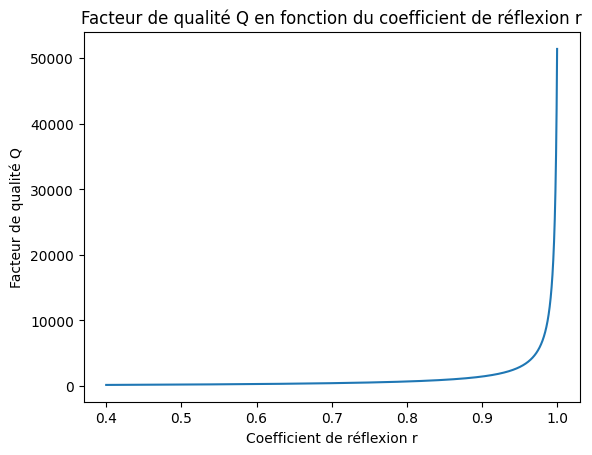

In [77]:
r_num1 = np.linspace(0.4, 1, 10000)
Q_num1 = calculate_Q(λ_1_num1, α_dB_num1, L_num1, r_num1, r_num1, n_eff_num1)
print(f"Le facteur de qualité Q pour r_1 = r_2 = {r_num1[-1]:.2f} est de {Q_num1[-1]:.2f}")

plt.plot(r_num1, Q_num1)
plt.xlabel("Coefficient de réflexion r")
plt.ylabel("Facteur de qualité Q")
plt.title("Facteur de qualité Q en fonction du coefficient de réflexion r")
plt.show()

Ici le facteur de qualité est limité par la perte de propagation de la cavité, par exemple pour $α = 50 \ [dB/cm]$ on obtient des valeurs différente.

In [78]:
α_2_num1 = 50  # en dB/cm
Q_2_num1 = calculate_Q(λ_1_num1, α_2_num1, L_num1, r_num1, r_num1, n_eff_num1)
print(f"Le facteur de qualité Q pour r_1 = r_2 = {r_num1[-1]:.2f} et α = {α_2_num1} dB/cm est de {Q_2_num1[-1]:.2f}")


Le facteur de qualité Q pour r_1 = r_2 = 1.00 et α = 50 dB/cm est de 10285.43


##### 1.E (2.5 points) Tracez la transmittance en dB de la cavité FP. Choisissez une plage de longueur d'onde autour de 1300 nm afin qu'on puisse observer 3 résonances. (supposer que r = 0.99 et que L est la valeur trouvée en B).

Nous devons à chaque longueur d'onde calculer la transmittance de la cavité, c'est à dire la fraction de puissance provenant d'un millieu $1$ qui sera transmit au millieu $3$ passant par la cavité le millieu $2$.

On prend la fonction de transfert de transfert d'une cavité fabry-pérot qui dicte l'intensité du champ électrique incidente et transmise.

$$
\frac{E_t}{E_{in}} = \cfrac{t_1t_2e^{-iβL}}{1-r_1r_2e^{-i2βL}}
$$

Je supose que nous somme à incidence normal alors
$$
β = kcos(θ) = k_0 \cos(0) = \frac{2πn}{λ}\\
$$

Comme nous avons aussi une atténuation dans le milieux, il faut prendre en compte la constante de propagation complexe qui transforme la fonction de transfert du FP.
$$ γ = β+ i α/2 $$
$$  \frac{E_t}{E_{in}} = \cfrac{t_1t_2e^{-iβL}e^{-αL/2}}{1-r_1r_2e^{-i2βL}e^{-αL/2}}    $$


Et le coefficient de réflection et transmission aux interfaces sont 
$$ R_{int}+T_{int}=1 \quad\bigg|\quad R_{int} = r^2 \quad\bigg|\quad T_{int} = t^2\\ $$
$$ r_1^2 + t_1^2 = 1 $$
$$ t_1 = \sqrt{1-r_1^2} $$

Ensuite, pour trouvé la transmitance, on doit mettre au carré la norme du ratio des amplitudes du champ électrique transmis et incident.
$$ T = \frac{\text{Intensité}_{t}}{\text{Intensité}_{in}} = \left|\frac{E_t}{E_{in}}\right|^2  = \left|\cfrac{t_1t_2e^{-iβL}e^{-αL/2}}{1-r_1r_2e^{-i2βL}e^{-αL/2}}\right|^2  $$

In [79]:
def calculate_γ(λ, n_eff, α_dB, θ):
    """ Calcule la constante de propagation complexe γ
    Prend la longueur d'onde λ, l'indice effectif n_eff, la perte α en dB/cm et l'angle θ en radians

    returns:
        γ : constante de propagation complexe
    """
    α_lin = (α_dB / 4.343) * 100  # Convertir dB/cm en 1/m

    # Attention α est une atténuation, donc on ajoute un terme imaginaire positif pour qu'il y ait une décroissance
    k = 2 * np.pi * n_eff / λ

    γ = k * np.cos(θ) - 1j * α_lin/2
    return γ


def calculate_FP_transfert_function(γ, L, r_1, r_2, t_1, t_2):
    """ Calcule la fonction de transfert d'une cavité de Fabry-Perot

    Paramètres:
        γ : constante de propagation complexe
        L : longueur de la cavité en m
        r_1, r_2 : coefficients de réflexion des miroirs

    Retourne:
        H : fonction de transfert complexe
    """
    
    H = (t_1 * t_2 * np.exp(-1j * γ * L)) / (1 - r_1 * r_2 * np.exp(-1j * 2 * γ * L))
    return H

def calculate_transmission(H=None, γ=None, L=None, r_1=None, r_2=None, t_1=None, t_2=None):
    """ Calcule la transmission d'une cavité de Fabry-Perot

    Paramètres:
        H (optional): La fonction de transfert complexe pré-calculée.
        γ, L, r_1, r_2, t_1, t_2 : arguments requis si H n'est pas fourni.

    Retourne:
        T : transmission (réelle)
    """
    
    # Check if H is provided
    if H is None:
        # If H is NOT provided, all other arguments must be present to calculate it.
        # Check for missing required arguments
        if None in (γ.all(), L, r_1, r_2, t_1, t_2):
            raise ValueError(
                "If 'H' is not provided, all arguments (γ, L, r_1, r_2, t_1, t_2) must be supplied."
            )
            
        # Calculate H using the required arguments
        H = calculate_FP_transfert_function(γ, L, r_1, r_2, t_1, t_2)
        
    # Proceed with the main calculation
    T = np.abs(H)**2
    return T

t_num1 = 0.141 | r_num1 = 0.990
L_num1 = 2.653e-05 m | n_eff_num1 = 2.450 | α_dB_num1 = 10 dB/cm


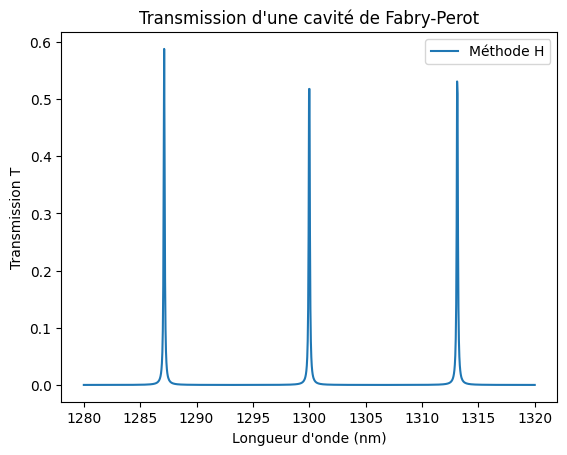

In [ ]:
λ_list_num1 = np.linspace(1280e-9, 1320e-9, 1000)
r_num1 = 0.99
t_num1 = np.sqrt(1-r_num1**2)


print(f"t_num1 = {t_num1:.3f} | r_num1 = {r_num1:.3f}")
print(f"L_num1 = {L_num1:.3e} m | n_eff_num1 = {n_eff_num1:.3f} | α_dB_num1 = {α_dB_num1} dB/cm")

# Calcul de γ pour chaque λ
γ_num1 = calculate_γ(λ_list_num1, n_eff_num1, α_dB_num1, 0)
# Calcul de la fonction de transfert H
H_num1 = calculate_FP_transfert_function(γ_num1, L_num1, r_num1, r_num1, t_num1, t_num1)
# Calcul de la transmission T
T_num1 = calculate_transmission(H=H_num1)


plt.plot(λ_list_num1*1e9, T_num1, label="Méthode H")
plt.xlabel("Longueur d'onde (nm)")
plt.ylabel("Transmission T")
plt.title("Transmission d'une cavité de Fabry-Perot")
plt.legend()
plt.show()




On oberse bien plusieurs pics au longueur d'onde de résonance de la cavité FB. Regardons l'influence du coefficient de réflexion de la cavité


In [83]:
def calculate_transmission_FP(λ, L, n_eff, α_dB, r_1, r_2):
    """ Calcule la transmission d'une cavité de Fabry-Perot

    Paramètres:
        λ : longueur d'onde en m
        L : longueur de la cavité en m
        n_eff : indice effectif du mode dans la cavité
        α_dB : perte en dB/cm
        r_1, r_2 : coefficients de réflexion des miroirs

    Retourne:
        T : transmission (réelle)
    """
    t_1 = np.sqrt(1 - r_1**2)
    t_2 = np.sqrt(1 - r_2**2)

    γ = calculate_γ(λ, n_eff, α_dB, 0)
    T = calculate_transmission(γ=γ, L=L, r_1=r_1, r_2=r_2, t_1=t_1, t_2=t_2)

    return T

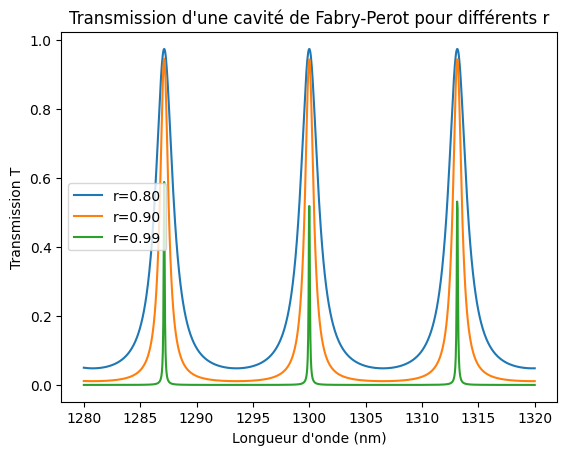

In [ ]:
r_list_num1 = [0.8, 0.9, 0.99]
for r in r_list_num1:
    T_num1 = calculate_transmission_FP(λ_list_num1, L_num1, n_eff_num1, α_dB_num1, r, r)
    plt.plot(λ_list_num1*1e9, T_num1, label=f"r={r:.2f}")
plt.xlabel("Longueur d'onde (nm)")
plt.ylabel("Transmission T")
plt.title("Transmission d'une cavité de Fabry-Perot pour différents r")
plt.legend()
plt.show()

On remarque que oui la finesse augmente avec le coefficient de réflexion mais l'atténuation selon la distance diminue aussi l'amplitude. On se retouve ainsi avec un compromis à faire entre FWHM et amplitud/perte.

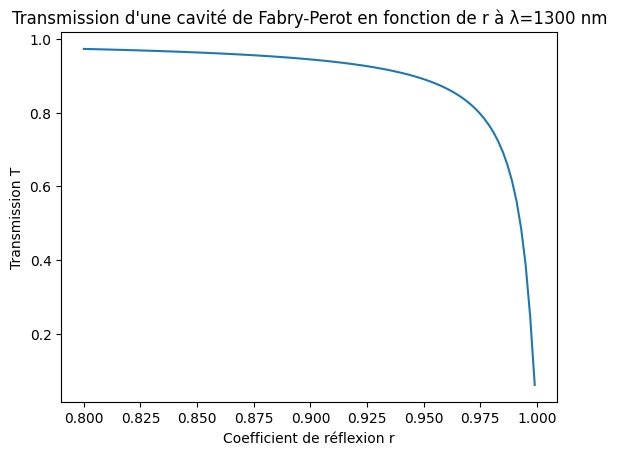

In [100]:
r_list_num1 = np.linspace(0.8, 0.999, 100)

T_max_at_r = []
for i in range(len(r_list_num1)):
    r = r_list_num1[i]
    T_num1 = calculate_transmission_FP(λ_1_num1, L_num1, n_eff_num1, α_dB_num1, r, r)
    T_max_at_r.append(T_num1)

plt.plot(r_list_num1, T_max_at_r)
plt.xlabel("Coefficient de réflexion r")
plt.ylabel("Transmission T")
plt.title("Transmission d'une cavité de Fabry-Perot en fonction de r à λ=1300 nm")
plt.show()

### Question 2 - Laser multimode (20%)
Considérez un laser multimode basé sur une cavité Fabry-Perot ayant les propriétés suivantes:

| Paramètres du laser | Symbole | Valeur | Unités |
| --- | :----: | :---: | :---: |
| Longueur de la cavité | $L$ | 100 | $\mu m$ |
| Facteur de confinement | $\Gamma$ | 0.1 | - |
| Indice de groupe | $n_g$ | 4.5 | - |
| Coefficient de réflexion des miroirs | $r_{1,2}$ | 0.8, 0.99 | - |
| Coefficient de pertes | $\alpha_i$ | 500 | $m^{-1}$ |
| Longueur d'onde centrale du gain | $\lambda_0$ | 0.95 | $\mu m$|
| Coefficient de gain nominal | $g_0$ | 2000 | cm $^{-1}$ |
| Largeur à mi-hauteur du gain | $\Delta \lambda$ | 20 | nm |
| Courant à la transparence | $I_{tr}$ | 1 | mA |

Utilisez une expression simplifiée de la dépendance spectrale du gain:

$$ g(I, \lambda) = \frac{g_0}{1 + \big(\frac{2(\lambda - \lambda_0)}{\Delta \lambda}\big)^2} \ln \frac{I}{I_{tr}} $$

Cette expression traite uniquement les valeurs positives de $g$. Assumez que l'indice de groupe, le facteur de confinement et le temps de vie des photons sont constants (ne dépendent pas de la longueur d'onde). Vous pouvez aussi ignorer la dispersion.


##### 2.A (5%)  Combien de modes longitudinaux de la cavité laser sont supportés dans la bande passante à 3dB (mi-hauteur) du gain?

In [ ]:
# - Réponse -
print("toto")

toto


##### 2.B (5%) Tracer le gain $g(I,\lambda)$ pour $I = [10, 15, 20, 25]$ mA ainsi que le gain seuil du laser $g_{th}$. Qu'en déduisez-vous?

In [ ]:
# - Réponse -

##### 2.C (5%) Quel est le courant seuil du mode central de la cavité? Sur quelle plage de courant le laser est-il monomode (émet un seul mode laser)?

In [ ]:
# - Réponse -

##### 2.D (5%) Proposez une méthode pour augmenter la plage d'opération monomode calculée en C. Justifiez avec un calcul.

In [ ]:
# - Réponse -

### Question 3 - Laser Fabry-Perot (20%)
Considérez un laser de Fabry-Perot avec les caractéristiques suivantes:

| Paramètre du laser | Symbole | Valeur | Unités |
| --- | :----: | :---: | :---: |
|Dimensions transverses de la cavité | $d \times w$ | 0.2 $\times$ 1 | $\mu m$ |
|Efficacité d'injection | $\eta_i$ | 0.9 | -|
|Longueur de la cavité | $L$ | 500 | $\mu$ m |
|Coefficient de pertes | $\alpha_i$ | 10 | cm $^{-1}$ |
|Facteur de confinement | $\Gamma$ | 0.01 | - |
|Indice de groupe | $n_g$ | 3.65 | - |
|Coefficient de réflexion des miroirs | $r_{1,2}$ | 0.99, 0.8 | - |
|Temps de vie des porteurs | $\tau$ | 3 | ns |
|Longueur d'onde d'émission| $\lambda_0$ | 900 | nm |
|Densité de porteurs à la transparence| $N_{tr}$ | $1.1 \times 10^{18}$ | $ cm ^{-3}$ |
|Coefficient de gain nominal| $g_0$ | 2000 | $cm ^{-1}$ |

Utilisez un modèle de gain  logarithmique tel que vu en classe et assumez le cas limite $g\ge0 $ et négligez la compression du gain ($\epsilon = 0$). Faites l'analyse pour un seul mode.

##### 3.A (5%) Calculer le courant de seuil du laser $I_{th}$.

In [ ]:
# - Réponse -

##### 3.B (5%) Quelle est la puissance émise *par chaque facette* en régime permanent pour un courant appliqué de $I = 3 I_{th}$.

In [ ]:
# - Réponse -

##### 3.C (5%) Quelle est l'efficacité quantique différentielle du laser? Quelle est la limite théorique maximale de l'efficacité quantique différentielle du laser?

In [ ]:
# - Réponse -

##### 3.D (5%) Proposez une façon d'augmenter l'efficacité quantique différentielle. Supportez par un calcul.

In [ ]:
# - Réponse -

### Question 4 -  Équation de taux d'une diode laser (50%)
Considérez une version simplifiée ($\Gamma = 1$, $G = \Gamma v_g g$) des équations de taux vues en classe:

$$ \frac{dN}{dt} = \eta_i \frac{I}{e} - \frac{N}{\tau} - G N_p$$
$$ \frac{dN_p}{dt} = R^{'}_{sp} + G N_p - \frac{N_p}{\tau_p}$$

Ici, $N$ et $N_p$ représente les quantités de porteurs et de photons et non les densités. Cette distinction est importante pour l'efficacité numérique de votre solution. 

Considérez un modèle linéaire pour le gain tel que:

$$ G(N) = \frac{G_0(N - N_{tr})}{1 + \epsilon N_p} $$

Ici $\epsilon$ est le facteur de compression du gain, à ne pas confondre avec la permittivité.

Les autres paramètres du laser sont:

| Paramètre du laser | Symbole | Valeur | Unités |
| --- | :----: | :---: | :---: |
|Temps de vie des photons | $\tau_p$ | 3 | ps |
|Temps de vie des porteurs | $\tau$ | 2 | ns |
|Taux d'émission spontanée | $R ^{'}_{sp}$ | 100 | ns $^{-1}$ |
|Facteur de gain | $G_0$ | $1 \times 10^{-5}$ | ns $^{-1}$ |
|Porteurs à la transparence| $N_{tr}$ | $4 \times 10^6$ | - |
|Efficacité d'injection | $\eta_i$ | 0.9 | - | 
|Facteur de compression du gain | $\epsilon$ | $2 \times 10^{-7}$ | - |
|Longueur d'onde d'émission | $\lambda_0$ | $1550$ | nm| 


##### 4.A (2.5%) Calculer *analytiquement* le courant de seuil et la quantité de porteurs au seuil du laser.

In [ ]:
# - Réponse -

##### 4.B (2.5%) Quelle est la quantité de porteurs en régime permanent, au-delà du seuil?

In [ ]:
# - Réponse -

*Pour le reste du problème* (C, D, E, F, G, H), vous devez résoudre les équations de taux numériquement en utilisant une librairie de Python (scipy.integrate par exemple) ou la méthode de Runge-Kutta 4 vue en classe.


##### 4.C (10%)

On vous demande d'abord de tracer les valeurs en régime permanent de $N$ et de $N_p$ en fonction du courant $I$. Le courant devrait être varier entre $I = 0$ mA et $I = 10$ mA.

Comment se compare ce que vous observez avec les valeurs obtenues en A et en B?

*** Conseil: exprimez votre variable de temps en $ns$ au lieu d'en $s$, encore une fois afin d'éviter les erreurs d'overflow. Attention à la conversion du courant. ***

*** Pour obtenir les valeurs en régime permanent, il suffit de résoudre les équations en temps jusqu'à l'atteinte de l'état stationnaire, puis de conserver seulement une valeur en R.P. ***

*** Pour résoudre les équations de taux, vous pouvez utiliser l'intégrateur numérique Runge-Kutta ou utiliser une fonction du module scipy (par exemple, https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)

In [ ]:
# - Réponse -

##### 4.D (5%) Tracer la puissance de sortie totale du laser (en mW) en régime permanent en fonction du courant appliqué (en mA). Assumez $\tau_m \approx \tau_p$.

In [ ]:
# - Réponse -

##### 4.E (5%) Sur un graphique, tracer la densité de photons en fonction du temps pour des courants de $I = 2 I_{th}$ et de $I = 5 I_{th}$ (deux courbes). Il faut donc résoudre les équations de taux de 0 ns à 5 ns en partant avec des valeurs initiales de $[N_0, N_{p,0}] = [0,0]$. Quel est le délai d'ouverture dans les deux cas? Qu'en déduisez-vous?

In [ ]:
# - Réponse -

##### 4.F (5%) Tracer la puissance de sortie du laser en fonction du temps pour un courant appliqué de $I = 2 I_{th}$ et de $I = 5 I_{th}$. Estimer la fréquence des oscillations d'ouverture dans les deux cas. Qu'en déduisez-vous?

In [ ]:
# - Réponse -

##### 4.G (5%) Tracer la réponse d'ouverture du laser: sur un graphique, tracer la quantité de photons vs la quantité de porteurs pour votre simulation faite en E, qu'observez-vous?

In [ ]:
# - Réponse -

##### 4.H (15%)
On vous demande maintenant de prédire la réponse fréquentielle du laser en modulation petit-signal, soit lorsque le courant appliqué a une petite composante AC superposée à une composante DC. On vous demande de le faire pour plusieurs valeurs de la composante DC: $I_{DC} = [1.2, 1.5, 2.5, 10] \times I_{th}$. 

Pour ce faire, appliqué d'abord le courant DC seulement et attendez que le laser atteigne l'état stationnaire. Ensuite, appliquez une petite perturbation au courant (un pulse). Continuer la simulation jusqu'à ce que les oscillations cessent (au moins 20 ns). Faites la transformée de Fourier des données à partir de l'introduction du pulse jusqu'à la fin de la simulation. On se rappel que la transformée de Fourier de la réponse temporelle d'un système avec une fonction delta appliquée nous donne la fréquence fréquentielle du système $S_{21}$.

Vous devez tracer la réponse fréquentielle pour chaque courant DC mentionné ci-haut et de trouver la fréquence de résonance du système. Comparez les résultats obtenus avec la réponse d'ouverture de votre laser, que remarquez-vous?

In [ ]:
# - Réponse -